### File organization

To keep our work organized, let's first create a space to keep all the files we will create for competition submissions.

In [ ]:
import os

os.mkdir('../comp_submissions/')

FileExistsError: [Errno 17] File exists: '../comp_submissions/'

In [ ]:
import os
print(os.getcwd())

/content


### Data imports

In [ ]:
import pandas as pd

url = "https://drive.google.com/file/d/1I6IjcShv00_tEHzHI9FElnyBQxbyiuDP/view?usp=drive_link"
path = "https://drive.google.com/uc?export=download&id="+url.split('/')[-2]
data = pd.read_csv(path, index_col="Id")

test_url = "https://drive.google.com/file/d/1VmAxsDfhDkR8xebPXYHwHK7KEVGaskjt/view?usp=drive_link"
test_path = "https://drive.google.com/uc?export=download&id="+test_url.split('/')[-2]
test_data = pd.read_csv(test_path, index_col="Id")

data

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,8450,65.0,856,3,0,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,9600,80.0,1262,3,1,0,2,298,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,11250,68.0,920,3,1,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,9550,60.0,756,3,1,0,3,0,0,0,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,14260,84.0,1145,4,1,0,3,192,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,7917,62.0,953,3,1,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,13175,85.0,1542,3,2,0,2,349,0,0,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,9042,66.0,1152,4,2,0,1,0,0,1,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


### Intuition model

In [ ]:
def dummy_function(df):
    df['Expensive'] = df.apply(lambda x: 1 if (x['TotalBsmtSF']>1000 and x['BedroomAbvGr']>3 and x['Fireplaces']>1) else 0, axis=1)
    return df

dummy_function(data)['Expensive']

,Expensive
Id,
1,0
2,0
3,0
4,0
5,0
...,...
1456,0
1457,0
1458,1


In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    FunctionTransformer(dummy_function).set_output(transform="pandas")
)

pipe.fit(data)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function dummy_function at 0x7f47e1ad1bd0>))])

In [ ]:
prediction_data = pipe.transform(data)
prediction_data['Expensive']

,Expensive
Id,
1,0
2,0
3,0
4,0
5,0
...,...
1456,0
1457,0
1458,1


To submit to the competition, predictions must be made on `test_data`.

In [ ]:
submission = pipe.transform(test_data)[["Expensive"]]
submission

submission.to_csv("../comp_submissions/classification_dummy.csv")

# Preprocessor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
set_config(display="diagram")
set_config(transform_output="pandas")

In [ ]:
y = data['Expensive'].copy()
X = data.drop('Expensive', axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
# 1. defining categorical & numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

In [ ]:
# 2. numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

# 3. categorical pipeline

# # 3.1 defining ordinal & onehot columns
# .get_indexer() get's the index to solve the problem described above about losing column names

ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual',
                'FireplaceQu', 'BsmtFinType2', 'HeatingQC', 'GarageQual', 'GarageCond', 'PoolQC']

onehot_cols = ['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir', 'Foundation', 'Alley', 'LotShape',
               'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical',
               'GarageType', 'Functional',  'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType',
               'SaleCondition']

# # 3.2. defining the categorical encoder

# # # 3.2.1. we manually establish the order of the categories for our ordinal feature (Cabin), including "N_A"
ExterQual_cats = ["N_A","Po","Fa","TA","Gd","Ex"]
ExterCond_cats = ["N_A","Po","Fa","TA","Gd","Ex"]
BsmtQual_cats = ["N_A","NA", "Po", "Fa","TA", "Gd", "Ex"]
BsmtCond_cats = ["N_A","NA", "Po", "Fa","TA", "Gd", "Ex"]
BsmtExposure_cats = ["N_A", "NA", "No", "Mn", "Av","Gd"]
BsmtFinType1_cats = ["N_A", "NA", "Unf", "LwQ", "Rec","BLQ","ALQ","GLQ"]
KitchenQual_cats = ["N_A", "Po", "Fa","TA", "Gd", "Ex"]
FireplaceQu_cats = ["N_A", "Po", "Fa","TA", "Gd", "Ex"]
BsmtFinType2_cats = ["N_A", "NA", "Unf", "LwQ", "Rec","BLQ","ALQ","GLQ"]
HeatingQC_cats = ["N_A", "Po", "Fa","TA", "Gd", "Ex"]
GarageQual_cats = ["N_A","NA", "Po", "Fa","TA", "Gd", "Ex"]
GarageCond_cats =  ["N_A","NA", "Po", "Fa","TA", "Gd", "Ex"]
PoolQC_cats = ["N_A","NA", "Fa","TA", "Gd", "Ex"]


# # # 3.2.2. defining the categorical encoder: a ColumnTransformer with 2 branches: ordinal & onehot
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=[ExterQual_cats, ExterCond_cats,BsmtQual_cats, BsmtCond_cats,
                                                   BsmtExposure_cats, BsmtFinType1_cats, KitchenQual_cats, FireplaceQu_cats,
                                                   BsmtFinType2_cats, HeatingQC_cats, GarageQual_cats, GarageCond_cats,
                                                   PoolQC_cats]), ordinal_cols),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_cols),
    ]
)

# # 3.3. categorical pipeline = "N_A" imputer + categorical encoder
categorical_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="N_A"),
                                 categorical_encoder
                                )

# 4. full preprocessing: a ColumnTransformer with 2 branches: numeric & categorical
full_preprocessing = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categorical_pipe, X_cat.columns),
    ]
)

full_preprocessing

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF',...
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])

# 1.Decision Tree Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# full pipeline: preprocessor + model
full_pipeline = make_pipeline(full_preprocessing,
                              DecisionTreeClassifier())

# define parameter grid
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    'decisiontreeclassifier__min_samples_leaf': range(3, 10, 2),
    'decisiontreeclassifier__min_samples_split': range(3, 40, 5),
    'decisiontreeclassifier__criterion':['gini', 'entropy']
}

In [ ]:
# define GridSearchCV
search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)

scores = {"dtree" : search.best_score_}

scores


Fitting 5 folds for each of 128 candidates, totalling 640 fits


{'dtree': 1.0}

In [ ]:
search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__min_samples_leaf': 3,
 'decisiontreeclassifier__min_samples_split': 3}

In [ ]:
accuracy_score(search.predict(X_test), y_test)

1.0

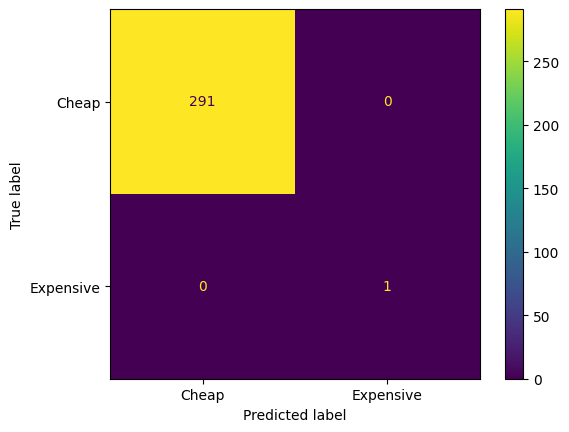

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search,
                                      X_test,
                                      y_test,
                                      display_labels=['Cheap', 'Expensive']);

# 2.Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_pipe = make_pipeline(
    full_preprocessing,
    RandomForestClassifier(random_state=42)
)

rf_param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": [100, 200, 300],
    "randomforestclassifier__max_depth": [None, 10, 20, 30],
    "randomforestclassifier__min_samples_split": [2, 5, 10]
}

search_rf = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    verbose=1,
    n_jobs=-2
)

search_rf.fit(X_train, y_train)
scores["random_forest"] = search_rf.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
search_rf.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 100}

In [ ]:
accuracy_score(search_rf.predict(X_test), y_test)

0.9965753424657534

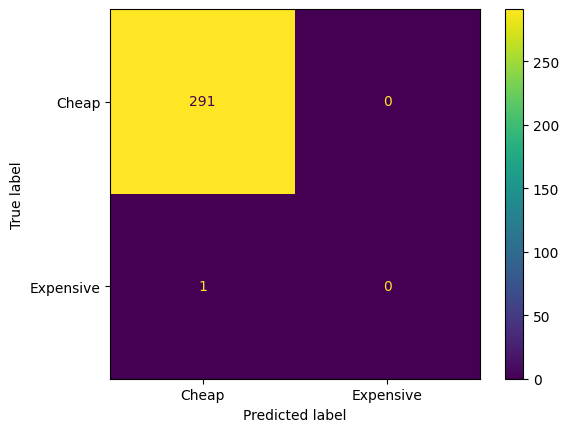

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search_rf,
                                      X_test,
                                      y_test,
                                      display_labels=['Cheap', 'Expensive']);

# 3.KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

knn_pipe = make_pipeline(full_preprocessing,
                        StandardScaler(),
                        KNeighborsClassifier())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "kneighborsclassifier__n_neighbors": range(1, 12, 2),
    "kneighborsclassifier__weights": ['uniform', 'distance']
}

search_knn = GridSearchCV(knn_pipe,
                      param_grid,
                      cv=5,
                      verbose=1,
                      n_jobs=-2)

search_knn.fit(X_train, y_train)

scores["knn"] = search_knn.best_score_

scores

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'dtree': 1.0, 'random_forest': 0.9811672352444883, 'knn': 0.9811672352444883}

In [ ]:
search_knn.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__weights': 'uniform'}

In [ ]:
accuracy_score(search_knn.predict(X_test), y_test)

0.9965753424657534

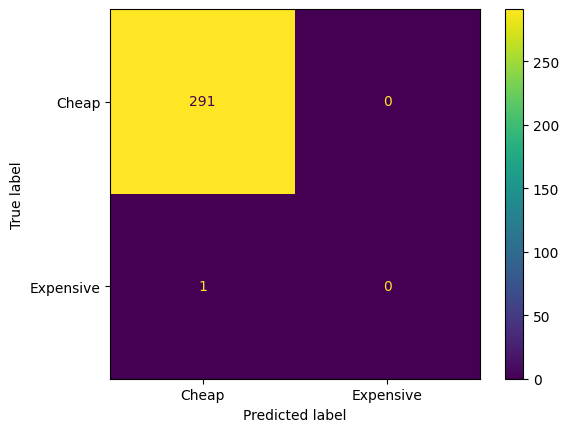

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search_knn,
                                      X_test,
                                      y_test,
                                      display_labels=['Cheap', 'Expensive']);

# 4.Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg_pipe = make_pipeline(
    full_preprocessing,
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

log_reg_param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "logisticregression__C": [0.01, 0.1, 1, 10, 100],
    "logisticregression__penalty": ['l2']
}

search_log_reg = GridSearchCV(
    log_reg_pipe,
    log_reg_param_grid,
    cv=5,
    verbose=1,
    n_jobs=-2
)

search_log_reg.fit(X_train, y_train)
scores["log_reg"] = search_log_reg.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
search_log_reg.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'logisticregression__C': 0.01,
 'logisticregression__penalty': 'l2'}

In [ ]:
accuracy_score(search_log_reg.predict(X_test), y_test)

0.9965753424657534

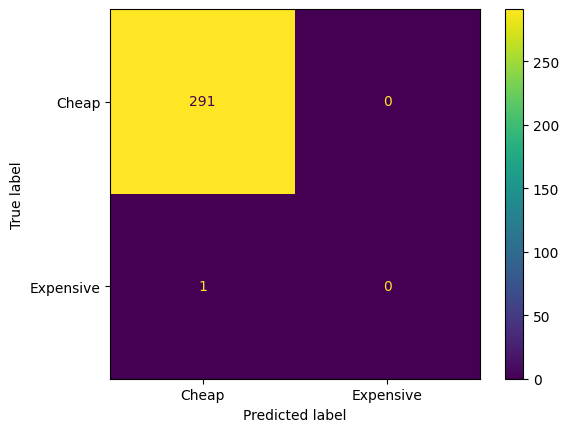

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search_log_reg,
                                      X_test,
                                      y_test,
                                      display_labels=['Cheap', 'Expensive']);

# 5.Support Vector Machine Model

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_pipe = make_pipeline(
    full_preprocessing,
    StandardScaler(),
    SVC()
)

svm_param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "svc__C": [0.1, 1, 10, 100],
    "svc__kernel": ['linear', 'rbf']
}

search_svm = GridSearchCV(
    svm_pipe,
    svm_param_grid,
    cv=5,
    verbose=1,
    n_jobs=-2
)

search_svm.fit(X_train, y_train)
scores["svm"] = search_svm.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
search_svm.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'svc__C': 0.1,
 'svc__kernel': 'rbf'}

In [ ]:
accuracy_score(search_svm.predict(X_test), y_test)

0.9965753424657534

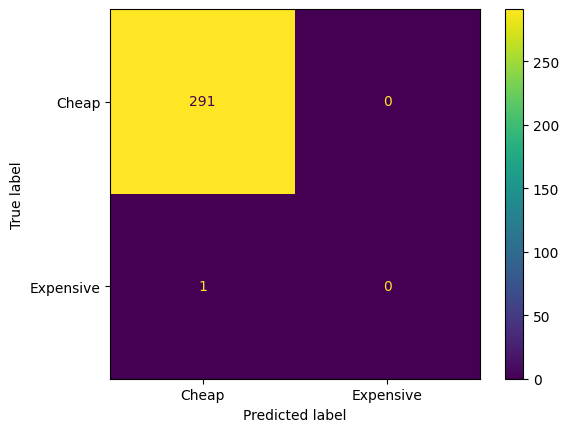

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search_svm,
                                      X_test,
                                      y_test,
                                      display_labels=['Cheap', 'Expensive']);

In [ ]:
scores

{'dtree': 1.0,
 'random_forest': 0.9811672352444883,
 'knn': 0.9811672352444883,
 'log_reg': 0.979454165291075,
 'svm': 0.9811672352444883}

# Results:

In [ ]:
full_pipeline.set_params(columntransformer__num_pipe__simpleimputer__strategy='mean', decisiontreeclassifier__criterion='entropy',
                         decisiontreeclassifier__min_samples_leaf = 3,decisiontreeclassifier__min_samples_split= 3)
full_pipeline.fit(X_train, y_train)
accuracy_score(y_true=y_train,
               y_pred=full_pipeline.predict(X_train))

1.0

In [ ]:
full_pipeline.score(X_test, y_test)

1.0

In [ ]:
full_pipeline.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
prediction = X_test.copy()
prediction['Expensive'] = full_pipeline.predict(X_test)
prediction['Expensive']

,Expensive
Id,
212,0
329,0
1274,0
564,0
411,0
...,...
1265,0
759,0
1187,0


In [ ]:
full_pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1'...
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3,
                                        min_samples_split=3))])

In [ ]:
DT_pred = test_data.copy()
DT_pred['Expensive'] = full_pipeline.predict(test_data)
DT_pred['Expensive'].to_csv('../comp_submissions/classification_DT.csv')

In [ ]:
scores


{'dtree': 1.0,
 'random_forest': 0.9811672352444883,
 'knn': 0.9811672352444883,
 'log_reg': 0.979454165291075,
 'svm': 0.9811672352444883}

# other

In [ ]:
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='N_A'),
                        OneHotEncoder(handle_unknown='infrequent_if_exist',
                                      sparse_output=False))
preprocessor = make_column_transformer((num_pipe, X_num.columns),
                                       (cat_pipe, X_cat.columns))

knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())

In [ ]:
knn_pipe.fit(X_train, y_train)
accuracy_score(y_true=y_train,
               y_pred=knn_pipe.predict(X_train))

0.797945205479452

In [ ]:
knn_pipe.set_params(kneighborsclassifier__n_neighbors=15, kneighborsclassifier__weights='distance')
knn_pipe.fit(X_train, y_train)
accuracy_score(y_true=y_train,
               y_pred=knn_pipe.predict(X_train))

1.0

In [ ]:
knn_pipe.score(X_test, y_test)

0.7157534246575342

In [ ]:
knn_pipe.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0], dtype=int64)

The output of `.predict()` is an array. This will have to be joined with `Id`s to create a suitable submission.

In [ ]:
prediction = X_test.copy()
prediction['Expensive'] = knn_pipe.predict(X_test)
prediction['Expensive']

Id
148     1
677     1
1305    0
1373    1
1428    1
       ..
1013    1
1060    1
891     0
629     1
353     0
Name: Expensive, Length: 292, dtype: int64

To maximize the use of our training data, we can `fit` one last time on the _full_ (unsplit) training data.

True prediction is then done on `test_data`.

In [ ]:
knn_pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF...
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [ ]:
knn_pred = test_data.copy()
knn_pred['Expensive'] = knn_pipe.predict(test_data)
knn_pred['Expensive'].to_csv('../comp_submissions/classification_knn_untrimmed.csv')